# Projeto

Um trabalho desenvolvido na disciplina de Machine Learning (Estatística-UFSM) para aplicar as técnicas de ML visando predizer o vencedor da Copa do Mundo FIFA 2022, simulando partida a partida da fase de grupo até a grande final.

Utilizando dois datasets como fontes [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) e [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking).

A estruturação do feature engineering presente nesse trabalho foi desenvolvida em [Soccer World Cup 2018 Winner](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). No entanto, foi realizado uma metodologia buscando uma acurácia melhor, adicionando pouca complexidade (covariáveis) ao modelo. 

Os modelos utilizados são para classificação binária para simplificação da modelagem e estruturação das variáveis, assim os modelos são para predizer vitória/derrota, com as partidas que foram empates sendo excluídas da modelagem. A probabilidade de vencer a partida é dada como a média de vencer a partida dentro de casa e fora de casa (pois na copa do mundo não tem vantagem de mandante).

O autor da modelagem para a previsão do vencedor da Copa do Mundo de 2018, que utilizei como base desse projeto, também realizou a modelagem para a Copa de 2022, estando disponível em [Predicting FIFA 2022 World Cup with ML](https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml).

In [1]:
import numpy as np 
import pandas as pd
import re 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from utils.modelling_functions import analyze, scraping, simulation_groups, simulation_playoff

# Modelagem 

Após a construção das variáveis e sua avaliação, nós temos os dataset prontos com colunas com poder preditivo interessante (como visto em feature_analysis), nós podemos começar a modelagem.

Nós iremos testar 3 modelos: Regressão Logística, Random Forest e Gradient Boosting. Selecionaremos o modelo com melhor Recall/Revocação/Sensibilidade.

In [2]:
model_db = pd.read_csv('data/modelling_dataset.csv')
team_stats_raw = pd.read_csv('data/team_stats_by_match.csv')

In [3]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [5]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1],
            "min_samples_split": [3, 5],
            "min_samples_leaf": [5, 7, 10],
            "max_depth":[3, 5],
            "max_features":["sqrt"],
            "n_estimators":[200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1, verbose = False)

In [6]:
gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [3, 5], 'n_estimators': [200]},
             verbose=False)

In [7]:
gb = gb_cv.best_estimator_

In [8]:
print(gb_cv.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 200}


In [9]:
params_rf = {
            "min_samples_split": [14, 15, 17],
            "min_samples_leaf": [5],
            "max_depth":[8],
            "max_features":["log2", "sqrt"],
            "max_leaf_nodes": [100],
            "criterion": ["entropy", "log_loss"],
            "n_estimators":[500]
         } 

rf = RandomForestClassifier(random_state=5)

rf_cv = GridSearchCV(rf, params_rf, cv = 5, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\user\anaconda3\lib\site-packages\joblib\

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'log_loss'], 'max_depth': [8],
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [100], 'min_samples_leaf': [5],
                         'min_samples_split': [14, 15, 17],
                         'n_estimators': [500]},
             verbose=False)

In [10]:
rf = rf_cv.best_estimator_

In [11]:
params_rlog = {"C": np.arange(0.01,0.5,0.05), "penalty":["l1","l2", "elasticnet", "none"], "max_iter" : [10000]}# l1 lasso l2 ridge
rlog = LogisticRegression()
logreg_cv = GridSearchCV(rlog, params_rlog, cv=5, n_jobs = -1, verbose = False)
logreg_cv.fit(X_train.values, np.ravel(y_train))

c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46]),
                         'max_iter': [10000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             verbose=False)

In [12]:
rlog = logreg_cv.best_estimator_
# # Predicting the Test set results
# y_pred = rf.predict(X_test)
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# # reversefactor = dict(zip(range(3),definitions))
# # y_test = np.vectorize(reversefactor.get)(y_test)
# # y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# pd.crosstab(np.ravel(y_test), y_pred)

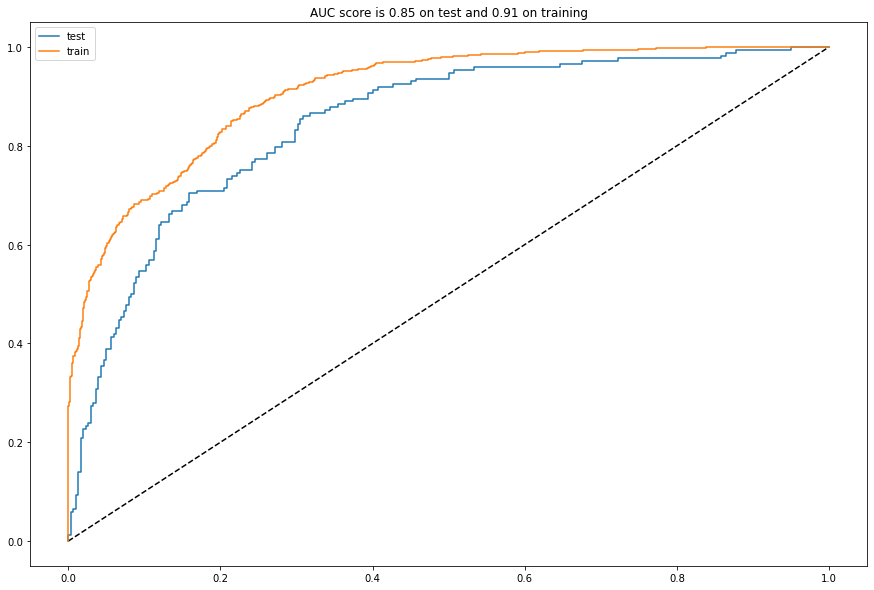

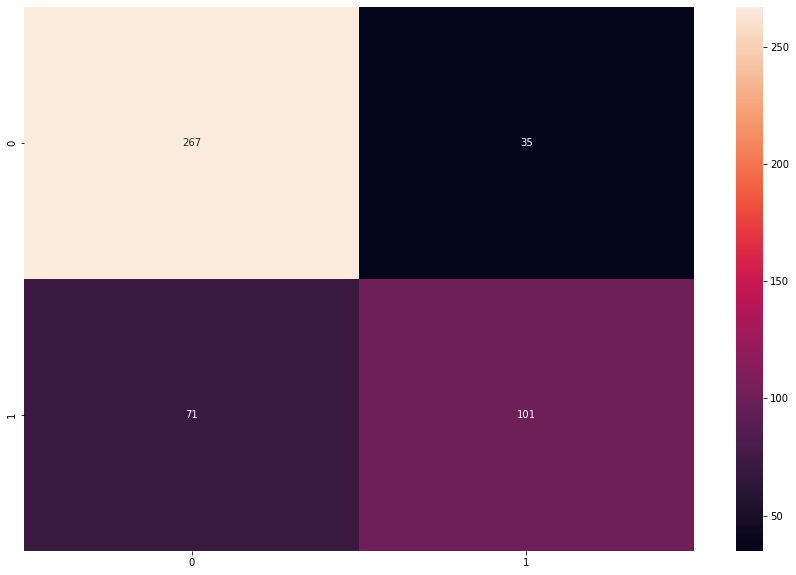

In [13]:
analyze(gb, y_train, y_test, X_train, X_test)

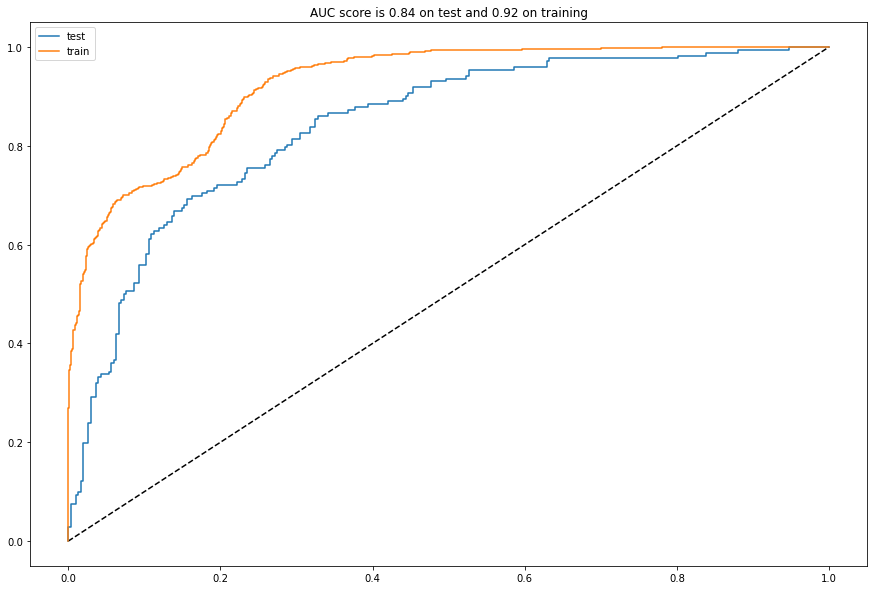

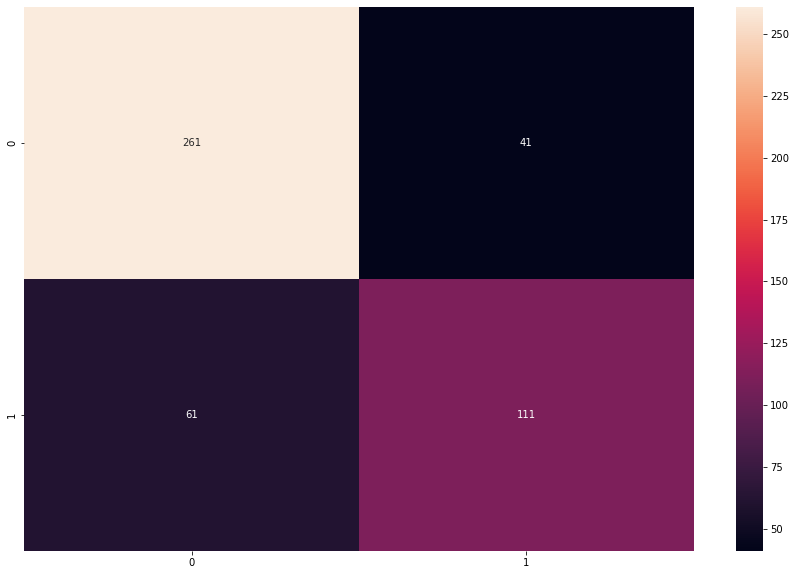

In [14]:
analyze(rf,  y_train, y_test, X_train, X_test)

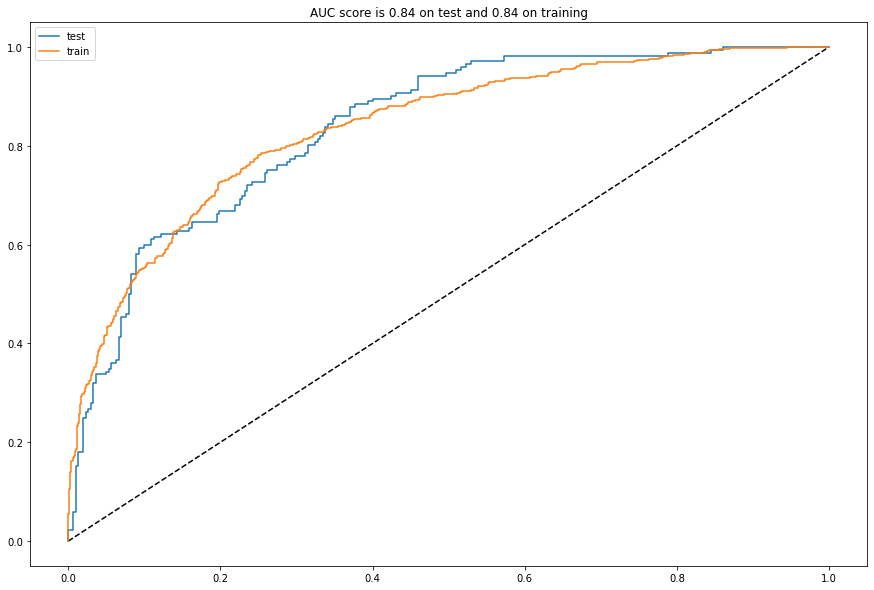

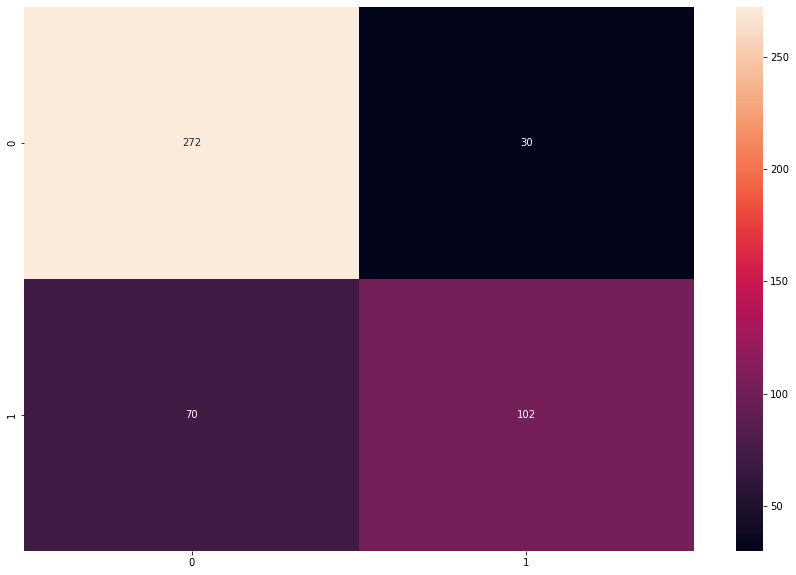

In [15]:
analyze(rlog,  y_train, y_test, X_train, X_test)

O modelo que irei escolher para a "previsão oficial" será o modelo de Random Forest, pois os outros ficaram mais underfittados ou menos constantes em sementes diferentes. 

# Simulação da Copa

Para podermos simularmos os jogos, primeiramente vamos realizar um Web Scraping do Wikipédia para conseguirmos pegar os grupos, times e partidas da primeira fase. 

In [16]:
matches, table, table_rf, table_rlog = scraping()

Com a construção do grupo e os participante, é possível armazenar os pontos dos times e a probabilidade de ganhar cada jogo. 

Caso exista empate nos pontos, a probabilidade de vencer vai ser usada como desempate (na realidade, é a verdadeira métrica para avanço).

In [17]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

Para a construção das variáveis vamos utilizar a última partida do time para que possamos pegar os valores de cada covariável.


In [18]:
team_stats_raw

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.00
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.50
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.50
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
6726,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
6727,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.00
6728,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.00


In [19]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games['score'].mean()
    team_1_goals_l5 = last5['score'].mean()
    team_1_goals_suf = past_games['suf_score'].mean()
    team_1_goals_suf_l5 = last5['suf_score'].mean()
    team_1_rank_suf = past_games['rank_suf'].mean()
    team_1_rank_suf_l5 = last5['rank_suf'].mean()
    team_1_gp_rank = past_games['points_by_rank'].mean()
    team_1_gp_rank_l5 = last5['points_by_rank'].mean()
    team_1_points_by_classification = past_games['points_by_classification'].mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5, team_1_points_by_classification]

In [20]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    dif_points_by_classification = team_1[9] - team_2[9]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0, dif_points_by_classification]

Agora com as funções ``find_stats()`` e ``find_features()`` podemos começar a simulação.

No entanto, temos que definir algumas regras como os datasets estão divididos em mandante e visitante, assim como na copa do mundo são sempre campos neutros, iremos simular a mesma partida invertendo os mandantes. 

Assim o empate será definido quando mudar o resultado de acordo com o mando de campo.

In [21]:
X.columns

Index(['rank_dif', 'goals_dif', 'goals_dif_l5', 'goals_suf_dif',
       'goals_suf_dif_l5', 'goals_per_ranking_dif', 'dif_rank_agst',
       'dif_rank_agst_l5', 'dif_points_rank', 'dif_points_rank_l5',
       'is_friendly_0', 'is_friendly_1', 'dif_points_by_classification'],
      dtype='object')

In [22]:
advanced_group = simulation_groups(table, gb, matches)



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: vencedor Netherlands com 64.45 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 67.89 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 70.76 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 64.08 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 65.30 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Senegal -------- 6
Qatar -------- 1
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 66.78 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 61.47 probabilidade
Grupo B - Wales x England: Empate
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 7
Wales -------- 3
United States -------

Praticamente não tivemos surpresas na frase de grupos, poderíamos dizer que as principais são os dois empates do Qatar com o Equador e principlamente com os Países Baixos, a classificação da Tunisia para no grupo da França, ao invés da Dinamarca e a classificação de Marrocos em grupo cheio de empates, com Bélgica e Marrocos se sobressaindo a Croácia e Canadá. 

In [23]:
advanced = advanced_group

In [24]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'Wales'],
 ['Argentina', 'Mexico'],
 ['France', 'Tunisia'],
 ['Spain', 'Germany'],
 ['Belgium', 'Morocco'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [25]:
playoffs = simulation_playoff(advanced, gb)

----------
Começando a simulação de Oitavas de Final
----------


Netherlands x Wales: Netherlands avança com probabilidade 59.76
Argentina x Tunisia: Argentina avança com probabilidade 64.85
Spain x Morocco: Spain avança com probabilidade 61.32
Brazil x Uruguay: Brazil avança com probabilidade 62.88
Senegal x England: England avança com probabilidade 66.02
Mexico x France: France avança com probabilidade 50.97
Germany x Belgium: Belgium avança com probabilidade 56.12
Switzerland x Portugal: Portugal avança com probabilidade 54.12
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 54.07
Spain vs. Brazil: Brazil avança com probabilidade 58.25
England vs. France: France avança com probabilidade 55.30
Belgium vs. Portugal: Belgium avança com probabilidade 60.27
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 52.57
France vs. Belgium: Belgium avan

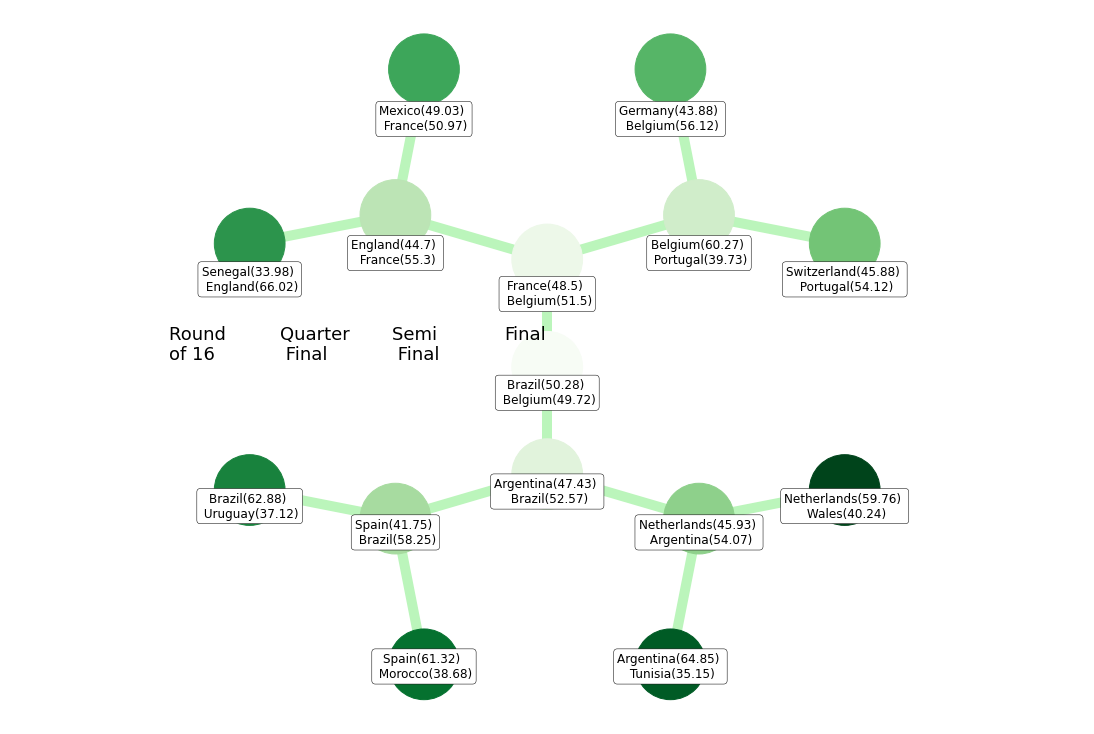

In [26]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

A previsão utilizando o modelo Gradient Boosting, prevê o Brasil como Hexa campeão. Com todas as partidas a partir das quartas sendo definidas nos detalhes, com probabilidades próximas ou menos a 0.6. Assim demonstrando a dificuldade e imprevisibilidade das partidas entre as favoritas. 

## Random forest

In [27]:
table = table_rf

In [28]:
advanced_group = simulation_groups(table, rf, matches)



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: vencedor Netherlands com 62.91 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 71.77 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 71.88 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 68.09 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 68.06 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Senegal -------- 6
Ecuador -------- 1
Qatar -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 68.55 probabilidade
Grupo B - United States x Wales: vencedor United States com 54.68 probabilidade
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 62.23 probabilidade
Grupo B - Wales x England: vencedor England com 63.18 probabilidade
Grupo B - Iran x United States: vencedor United 

As surpresas do modelo Gradient Boosting, já eram poucas, no entanto agora com a Random Forest são praticamente zeradas, com as favoritas passandos em todos os grupos e nas primeiras colocações. 

In [29]:
advanced = advanced_group

In [30]:
playoffs = simulation_playoff(advanced, rf)

----------
Começando a simulação de Oitavas de Final
----------


Netherlands x United States: Netherlands avança com probabilidade 54.60
Argentina x Denmark: Argentina avança com probabilidade 60.71
Spain x Croatia: Spain avança com probabilidade 60.15
Brazil x Uruguay: Brazil avança com probabilidade 65.66
Senegal x England: England avança com probabilidade 67.26
Mexico x France: France avança com probabilidade 55.03
Germany x Belgium: Belgium avança com probabilidade 61.85
Switzerland x Portugal: Portugal avança com probabilidade 56.84
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 57.12
Spain vs. Brazil: Brazil avança com probabilidade 59.48
England vs. France: France avança com probabilidade 53.62
Belgium vs. Portugal: Belgium avança com probabilidade 60.95
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 52.27
France vs. Belgium: Fran

A Random Forest também prevê o hexa, mas com uma diferença mínima de apenas 0.40. O caminho para o Hexa, assim como o grupo da fase de entrada, deve ser o mais difícil da história, mas mesmo assim, os modelos prevém o Brasil como grande favorito.

## Regressão Logística

In [31]:
table = table_rlog

In [32]:
advanced = simulation_groups(table, rlog, matches)



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: Empate
Grupo A - Qatar x Senegal: vencedor Senegal com 73.94 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 79.17 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 77.89 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 75.36 probabilidade


Grupo A classificados: 
Netherlands -------- 7
Senegal -------- 7
Qatar -------- 1
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: Empate
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: Empate
Grupo B - Wales x England: Empate
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 3
Wales -------- 3
United States -------- 3
Iran -------- 3


---------- Começando a simulação para o Grupo C ----------
Grupo C - Argentina x Sau

O modelo com certeza com mais surpresas, começando com a previsão de emppate e Senegal e Países Baixos (o que não aconteceu), o grupo B com *TODOS* os jogos sendo empates, diminuindo e muito o favoritismo inglês, sendo definido apenas nos critérios de desempate. 

No grupo D, os times são equivalentes apenas conseguem vencer da Australia, mas empatam entre si, no entando a zebra Tunisia não consegue passar da fase de grupos e avançam França e Dinamarca. No grupo E, apenas uma vitória entre Alemanha e Costa Rica, com a Alemanha se classificando em primeiro e a Espanha ganha do Japão nos critérios de desempate. O grupo F é muito semelhante ao grupo D, os times apenas conseguem vencer o Canadá, mas empatem entre si, assim avançam Bélgica e Marrocos (zebra) ao invés da Croácia. 

No grupo do Brasil, apenas o Brasil consegue vencer e os outros times empatam, assim a Sérvia se classifica pelos critérios de desempate. No grupo H, acontece a mesma coisa que no grupo F e D, assim avança Portugal e Uruguai ao invés da Coreia do Sul e Gana (que perde todos os jogos).

Nota-se que ao contrário dos modelos anteriores, é uma tendência da Regressão Logística a ter muitos empates. 

In [33]:
advanced = advanced_group

In [34]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [35]:
playoffs = simulation_playoff(advanced, rlog)

----------
Começando a simulação de Oitavas de Final
----------


Netherlands x United States: Netherlands avança com probabilidade 55.77
Argentina x Denmark: Argentina avança com probabilidade 59.57
Spain x Croatia: Spain avança com probabilidade 57.67
Brazil x Uruguay: Brazil avança com probabilidade 66.58
Senegal x England: England avança com probabilidade 55.51
Mexico x France: Mexico avança com probabilidade 51.17
Germany x Belgium: Belgium avança com probabilidade 51.04
Switzerland x Portugal: Portugal avança com probabilidade 54.35
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 57.69
Spain vs. Brazil: Brazil avança com probabilidade 65.14
England vs. Mexico: England avança com probabilidade 53.95
Belgium vs. Portugal: Belgium avança com probabilidade 52.99
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 57.21
England vs. Belgium: En

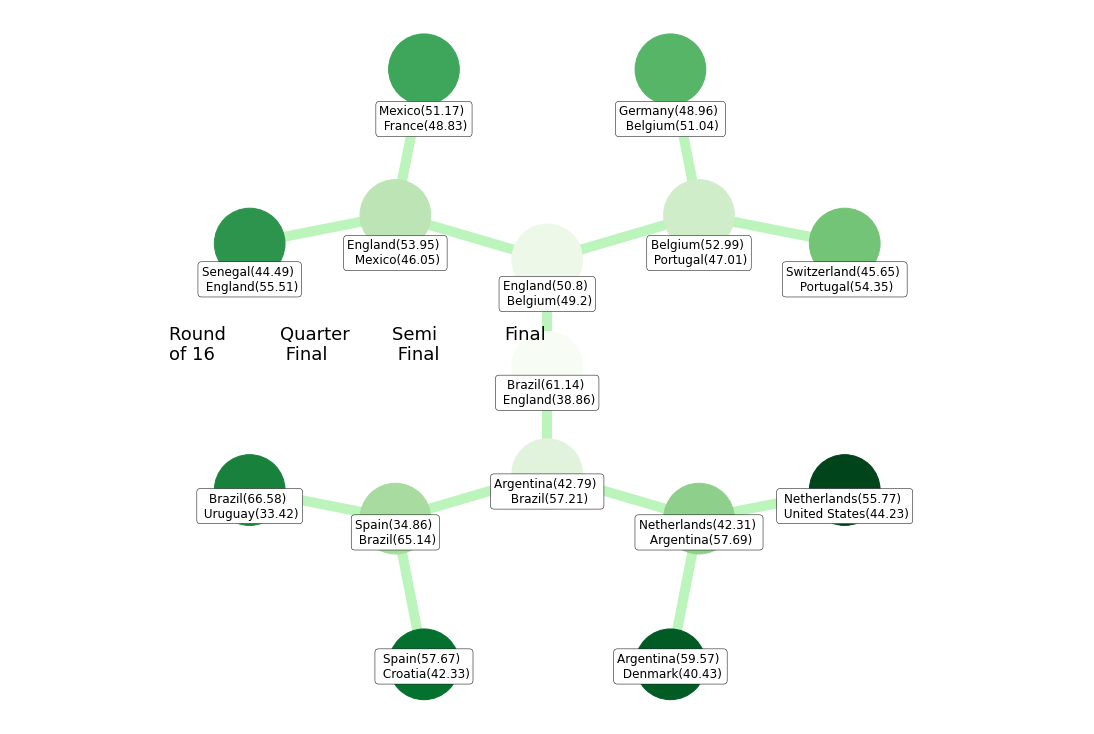

In [36]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

Aparentemente todos os caminhos levam ao Hexa, com o Brasil conquistando o títulos nas três simulações. Destaca-se o número de empates na Regressão Logística e as poucas zebras que acontecem durante a Copa do Mundo (uma dificuldade nítida dos modelos de ML). Assim, o Brasil com um caminho muito difícil, o lado de mata-mata mais difícil e uma fase de grupo competitiva, consegue nas três previsões avançar sobre todos esse percalços e conquistar o Hexa.